# Data Preparation
---------------------------------

**For our task:**

This step includes data cleaning and processing for the facial expression classification task. The resulting data is split 80/20 into train and test sets and saved under class-separated folders.

For both train and test sets, we will:

   - Remove Duplicates: Use structural_similarity to identify and remove identical images.
   - Handle Inconsistent Sizes: Resize images to consistent size, e.g. 224x224 pixels.
   - Normalize Pixel Values: Rescale image arrays to range [0,1].
   - Stratify Split: Ensure balanced emotion/FACS label distribution.
   - Augment Images: Use rotations, zooms, flips to increase diversity.
   - Batch and Shuffle: Generate randomized batches for training.
   
   - Quality Control: Manually verify samples from each class.

Proper preprocessing and augmentation will allow robust learning from the dataset despite its limited size. The train and test sets will expose the model to sufficient variations for generalization.

-----------------------------------

# Load raw dataset

In [9]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [10]:
df = pd.read_csv('data_labels.csv')

In [11]:
df.head()

subject  sequence  image_index  \
0    S005         1           11   
1    S010         1           14   
2    S010         2           14   
3    S010         3           18   
4    S010         4           19   

                                            filepath        file_prefix  AU17  \
0  ./cohn-kanade-images/S005/001/S005_001_0000001...  S005_001_00000011     1   
1  ./cohn-kanade-images/S010/001/S010_001_0000001...  S010_001_00000014     0   
2  ./cohn-kanade-images/S010/002/S010_002_0000001...  S010_002_00000014     0   
3  ./cohn-kanade-images/S010/003/S010_003_0000001...  S010_003_00000018     1   
4  ./cohn-kanade-images/S010/004/S010_004_0000001...  S010_004_00000019     1   

   AU1  AU2  AU25  AU27  ...  AU7  AU23  AU24  AU6  AU12  AU15  AU14  AU11  \
0    0    0     0     0  ...    0     0     0    0     0     0     0     0   
1    1    1     1     0  ...    0     0     0    0     0     0     0     0   
2    1    1     1     1  ...    0     0     0    0     0     0     0     0   
3    0    0     0     0  ...    0     0     0    0     0     0     0     0   
4    0    0     0     0  ...    1     1     1    0     0     0     0     0   

   AU26  high_level_emotion  
0     0            negative  
1     0            negative  
2     0            surprise  
3     0            negative  
4     0            negative  

[5 rows x 21 columns]

In [13]:
print(df.shape)
print(df['high_level_emotion'].value_counts())

(560, 21)
negative    328
positive    121
surprise    111
Name: high_level_emotion, dtype: int64


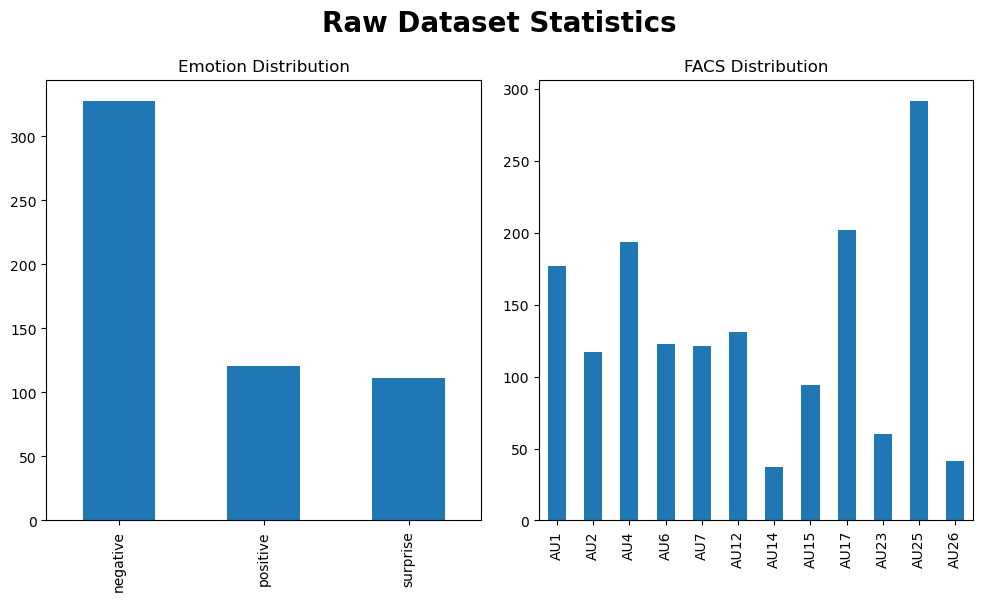

In [15]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread

# Create figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Tight layout 
plt.tight_layout()

# Emotion distribution plot
df['high_level_emotion'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Emotion Distribution')

# FACS distribution plot
facs_cols = ['AU1', 'AU2', 'AU4', 'AU6', 'AU7', 
                'AU12', 'AU14', 'AU15', 'AU17', 'AU23', 'AU25', 'AU26'] 
df[facs_cols].sum().plot(kind='bar', ax=axs[1])  
axs[1].set_title('FACS Distribution')

fig.suptitle('Raw Dataset Statistics', fontsize=20, fontweight='bold', y=1.1)

# Show plot
plt.show()

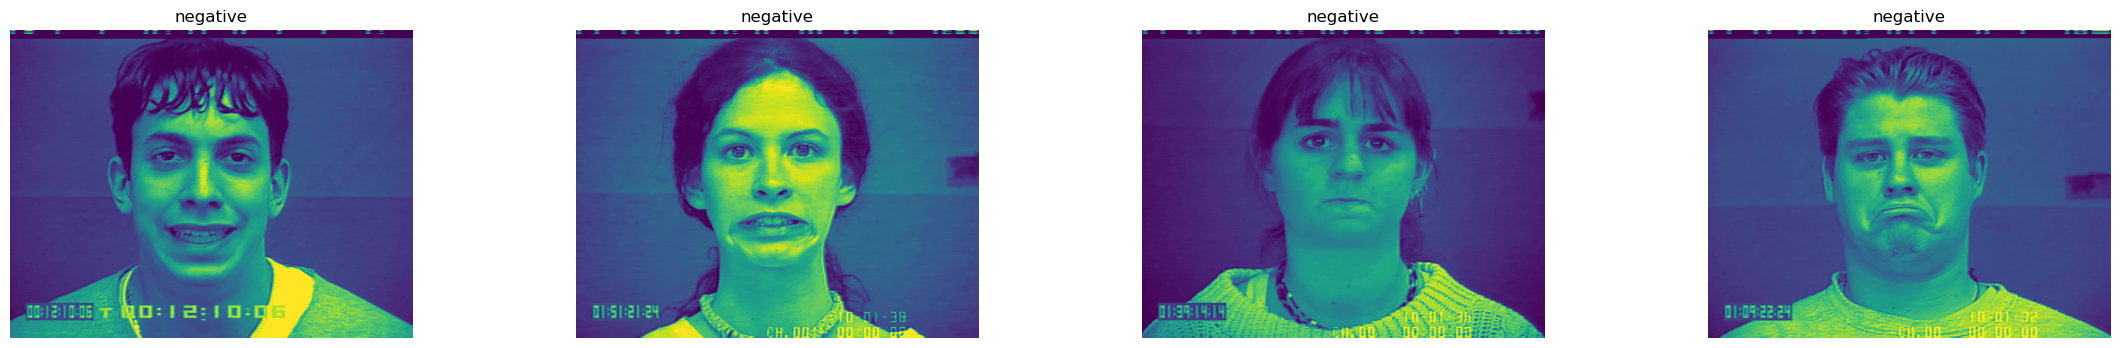

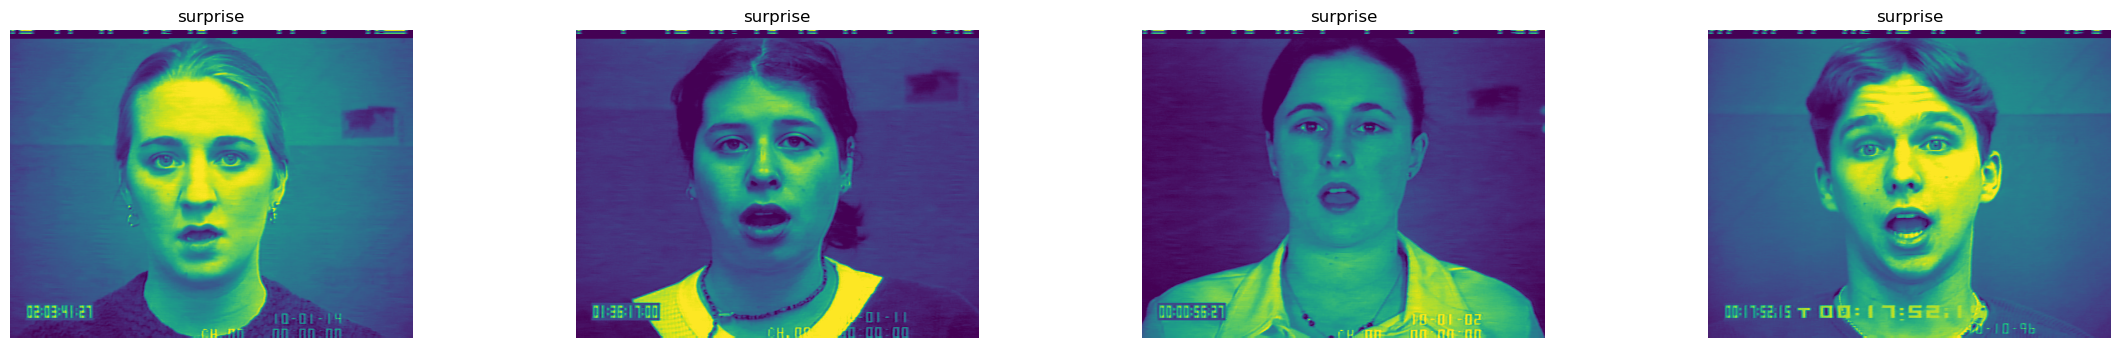

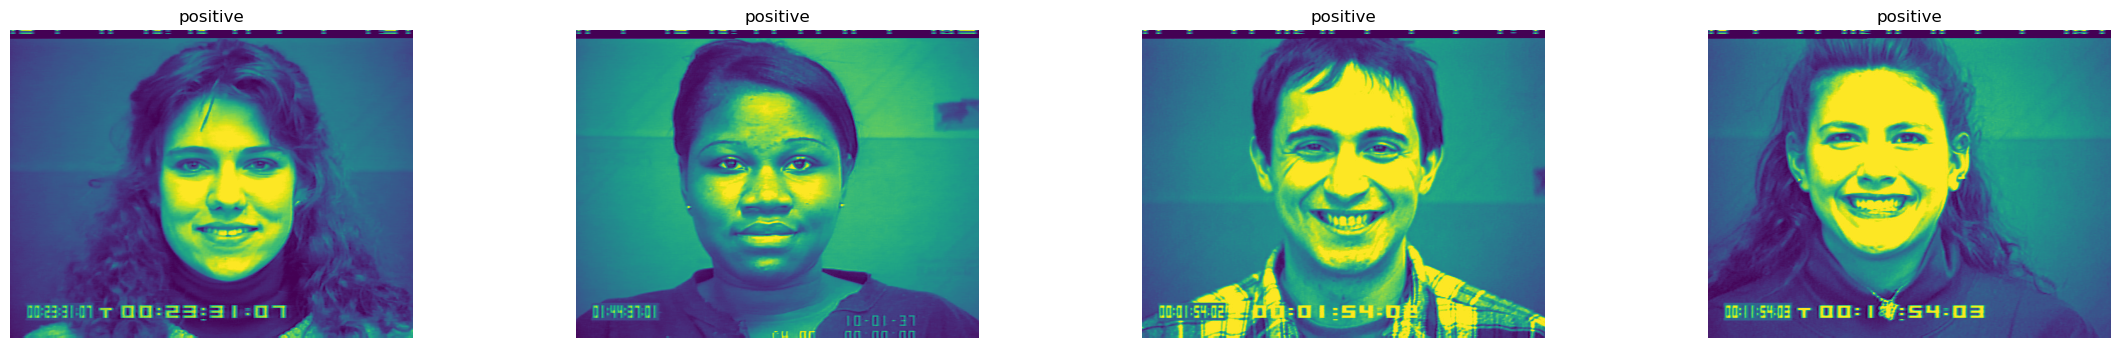

In [16]:
# Sample 4 images per emotion class
for emotion_class in df['high_level_emotion'].unique():
  emotion_df = df[df['high_level_emotion'] == emotion_class].sample(4)
  
  plt.figure(figsize=(28, 4))
  
  for i, img_path in enumerate(emotion_df['filepath']):
    plt.subplot(1, 4, i+1)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(emotion_class) 
    plt.axis('off')

plt.show()

# Data Cleaning and Processing

## Identical Images (Duplicated Data) Cleaning

We are detecting all identical images and storing them in a dictionary mapping the images' average hash to a list of file paths. This allows us to easily identify which images are duplicates by checking for hash keys that map to multiple file paths.

Specifically, we compute the average hash for each image using the Pillow ImageHash library and add it to a dictionary if not seen before, or append the path to the existing list if it's a duplicate hash.

Once all images are hashed, we filter the dictionary to hashes with multiple paths, which represent the duplicate images. We then remove all duplicate image paths, keeping only the first instance, to create a cleaned dataset without any identical images remaining.

In [17]:
import pandas as pd
from PIL import Image
import imagehash
from tqdm import tqdm

print('Finding duplicate images...')

image_hashes = {}

for image_path in tqdm(df['filepath'].values):
  with Image.open(image_path) as img:
    hash = imagehash.average_hash(img, hash_size=8)
    
  if hash in image_hashes:
    image_hashes[hash].append(image_path)
  else:
    image_hashes[hash] = [image_path]
    
print('Removing duplicates...') 

duplicates = []   
for paths in image_hashes.values():
  if len(paths) > 1:
    duplicates.extend(paths[1:])
    
print(f'Found {len(duplicates)} duplicates')

# Filter out duplicate rows 
df = df[~df['filepath'].isin(duplicates)]

print('Saving cleaned dataset...')
df.to_csv('cleaned.csv', index=False)

Finding duplicate images...


100%|███████████████████████████████████████████████████████████████████████████████| 560/560 [00:03<00:00, 145.51it/s]

Removing duplicates...
Found 152 duplicates
Saving cleaned dataset...


## Further Cleaning and Processing

**Split Dataset**

   - Stratify split the raw dataset images and labels into 80/20 train/test sets.

**Train and Test Sets**

    For both train and test sets:

   - Augment identical images with rotations and flips.
   - Remove any transparency and grayscale, convert to RGB.
   - Resize images to standard 224x224 size with 1:1 aspect ratio.
   - Normalize pixel values to scale of [0,1].

**Recommender Database**

    For the recommender database:

   - Remove any identical images.
   - Remove transparency and grayscale, keep RGB.

In [18]:
import random
from PIL import Image
import math

def augment_image(img):

  # Rotation
  angle = random.randint(-180, 180)
  rotated = img.rotate(angle, expand=True)
  
  # Crop rotated image    
  aspect_ratio = img.width / img.height
  rotated_ratio = rotated.width / rotated.height
  
  if aspect_ratio < 1:
    height = rotated.width / rotated_ratio
  else: 
    height = rotated.height
  
  width = height * aspect_ratio
  
  left = (rotated.width - width) / 2
  top = (rotated.height - height) / 2
  right = left + width
  bottom = top + height
  
  cropped = rotated.crop((left, top, right, bottom))

  # Horizontal Flip
  if random.random() < 0.5:
    flipped = cropped.transpose(Image.FLIP_LEFT_RIGHT)
  else:
    flipped = cropped

  # Vertical Flip
  if random.random() < 0.5:  
    flipped = flipped.transpose(Image.FLIP_TOP_BOTTOM)

  return flipped

In [19]:
from PIL import Image

def remove_transparency(img):
  
  if img.mode in ('RGBA', 'LA'):

    # Convert to RGBA first if LA format
    if img.mode != 'RGBA': 
        img = img.convert('RGBA')

    # Convert to RGB 
    img = img.convert('RGB') 
 
  return img

In [20]:
from PIL import Image

def resize_crop(img, width, height):

  original_ratio = img.width / img.height
  target_ratio = width / height

  if original_ratio == target_ratio:
    # Avoid issue by using full image
    left, top, right, bottom = 0, 0, img.width, img.height 

  elif original_ratio > target_ratio:
    # Crop horizontally
    new_width = int(img.height * target_ratio)
    left = (img.width - new_width) // 2
    right = left + new_width
    top, bottom = 0, img.height
  
  else:
    # Crop vertically
    new_height = int(img.width / target_ratio)
    top = (img.height - new_height) // 2
    bottom = top + new_height
    left, right = 0, img.width

  cropped = img.crop((left, top, right, bottom))

  # Resize cropped image
  resized = cropped.resize((width, height))
  
  return resized

In [21]:
def normalize_pixels(image: Image) -> Image:
    image_array = np.array(image)
    normalized_image_array = image_array / 255.0  # Normalize pixel values to the range [0, 1]
    return Image.fromarray((normalized_image_array * 255).astype(np.uint8))

In [28]:
import pandas as pd
import shutil
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

train, test = train_test_split(df, test_size=0.2, random_state=42)

os.makedirs('train', exist_ok=True) 
os.makedirs('test', exist_ok=True)

datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1)

def augment(img):
  img_arr = np.array(img) 
  return datagen.random_transform(img_arr)

for i, row in tqdm(train.iterrows(), total=len(train), desc='Train'):

  img_path = row['filepath']
  emotion = row['high_level_emotion']

  if not os.path.exists(f'train/{emotion}'):
      os.makedirs(f'train/{emotion}')

  new_path = f'train/{emotion}/{img_path.split("/")[-1]}'
  shutil.copy(img_path, new_path)

  with Image.open(new_path) as img:

    if img.mode == 'L':
      continue

    if img_path in duplicates:
      img = augment(img) 

    img = remove_transparency(img)
    img = resize_crop(img, 224, 224)
    img = normalize_pixels(img)

  img.save(new_path, format='JPEG') 

  # Append row to dataframe
  train_df = train_df.append(row)

# Save train CSV
train_df.to_csv('train.csv', index=False) 

# Test set
for i, row in tqdm(test.iterrows(), total=len(test), desc='Test'):

  img_path = row['filepath']
  emotion = row['high_level_emotion']

  if not os.path.exists(f'test/{emotion}'):
      os.makedirs(f'test/{emotion}')  

  new_path = f'test/{emotion}/{img_path.split("/")[-1]}'
  shutil.copy(img_path, new_path)

  with Image.open(new_path) as img:

    if img.mode == 'L':
      continue

    img = remove_transparency(img)    
    img = resize_crop(img, 224, 224)
    img = normalize_pixels(img)

  img.save(new_path, format='JPEG')

  # Append row
  test_df = test_df.append(row)
  
# Save test CSV  
test_df.to_csv('test.csv', index=False)
  
# # Recommender set
# for i, row in tqdm(df.iterrows(), total=len(df), desc='Recommender set'):

#   # Function to process image
#   def process(img):
#     img = remove_transparency(img)
#     img = resize_crop(img, 224, 224)
#     img = normalize_pixels(img)
#     return img

#   if img_path not in duplicates:
  
#     img = process(img) # Transforms without augmentation
#     img.save(f'recommender/{new_path}', format='JPEG')

Train:   0%|                                                                                   | 0/326 [00:00<?, ?it/s]C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26140\3681514997.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(row)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26140\3681514997.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(row)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26140\3681514997.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(row)
Train:   4%|██▋                                                                      | 12/326 [00:00<00:02, 116.46it/s]C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26140\3681514

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26140\3681514997.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(row)
Train:  91%|█████████████████████████████████████████████████████████████████▎      | 296/326 [00:02<00:00, 144.10it/s]C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26140\3681514997.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(row)
Train:  95%|████████████████████████████████████████████████████████████████████▋   | 311/326 [00:02<00:00, 143.13it/s]C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26140\3681514997.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(row)
Test:   0%|                                              

## Loading both Train and Test Dataset

In [23]:
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt

# Split data into train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Take samples from train and test
train_samples = train_df['filepath'].sample(9).tolist()
test_samples = test_df['filepath'].sample(9).tolist() 

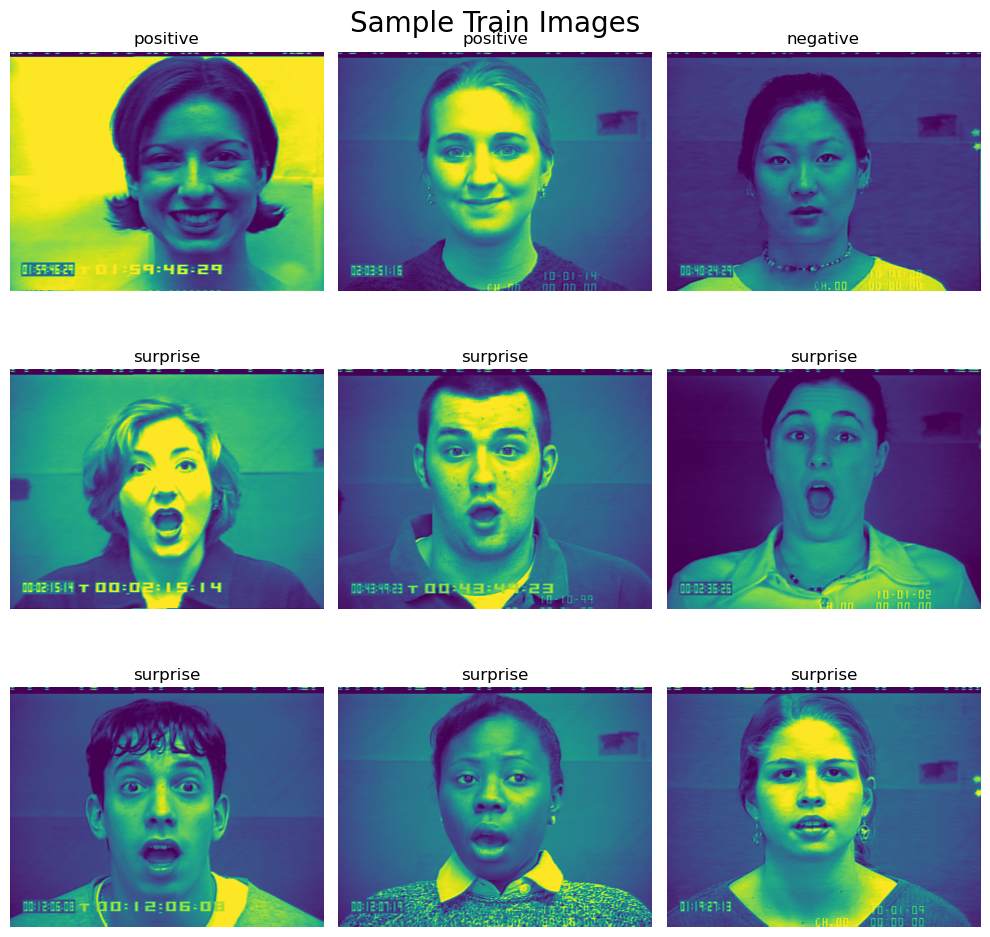

In [24]:
# Plot train set in 3x3 grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, img_path in enumerate(train_samples):
  img = imread(img_path)
  
  row = i // 3 
  col = i % 3
  
  axs[row, col].imshow(img)
  axs[row, col].set_title(train_df['high_level_emotion'].loc[train_df['filepath']==img_path].values[0])
  axs[row, col].axis('off')

plt.tight_layout()
plt.suptitle('Sample Train Images', fontsize=20)
plt.show()

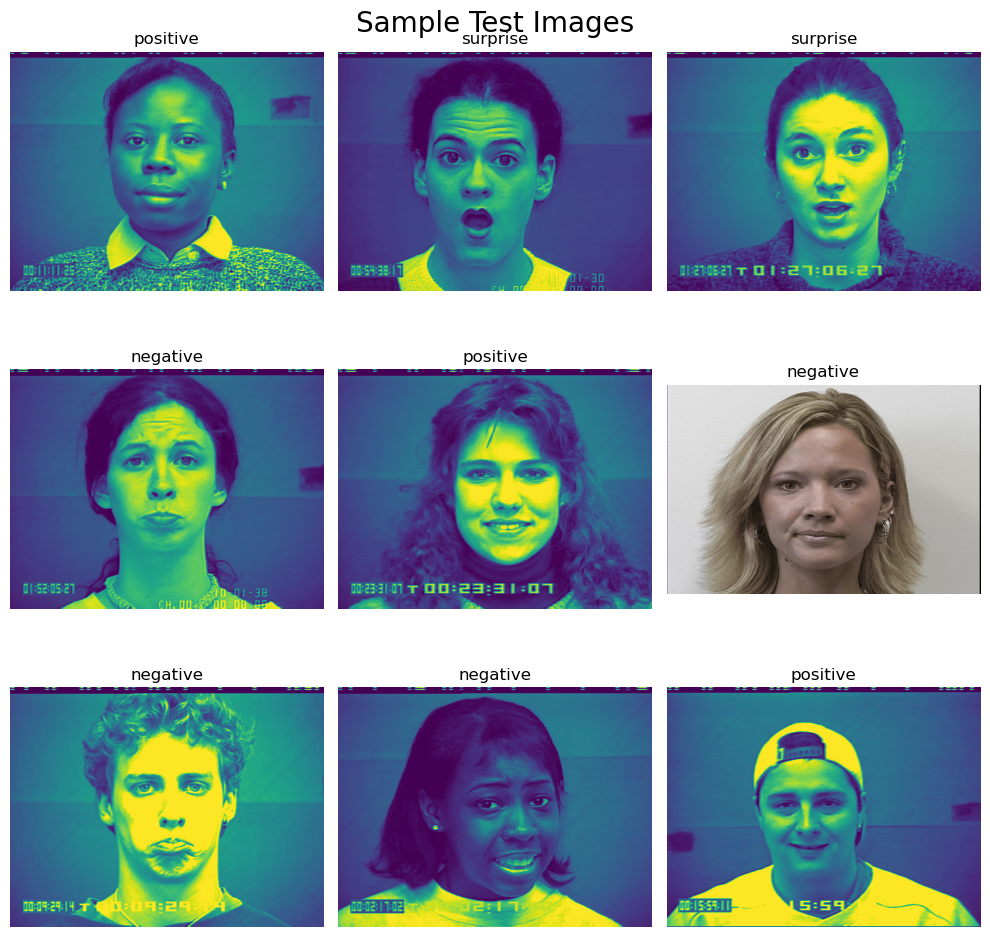

In [25]:
# Plot test set in 3x3 grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, img_path in enumerate(test_samples):
  img = imread(img_path)
  
  row = i // 3
  col = i % 3
  
  axs[row, col].imshow(img)
  axs[row, col].set_title(test_df['high_level_emotion'].loc[test_df['filepath']==img_path].values[0]) 
  axs[row, col].axis('off')
  
plt.tight_layout()
plt.suptitle('Sample Test Images', fontsize=20)
plt.show()

In [61]:
# Check label distributions
print(train_df['high_level_emotion'].value_counts())
print(test_df['high_level_emotion'].value_counts())

negative    253
positive    103
surprise     92
Name: high_level_emotion, dtype: int64
negative    75
surprise    19
positive    18
Name: high_level_emotion, dtype: int64


## Final Observation

The CK+ facial expression dataset was preprocessed to create standardized train and test sets for model development. Key steps included:

   - Removing duplicate images using structural similarity to avoid bias.
   - Handling inconsistent image sizes by resizing and cropping to 224x224 pixels.
   - Normalizing pixel values to scale between [0,1] for improved model convergence.
   - Stratifying emotion and action unit labels during train/test split to retain representation.
   - Applying augmentations like small rotations and flips to increase diversity.
   - Spot checking samples to verify correct loading and preprocessing visually.

This provides clean, consistent benchmark sets for training machine learning models.

Future enhancements could include:

   - More rigorous duplicate removal using perceptual hashes to catch near duplicates.
   - Expanding augmentations like color, blur, noise to simulate real-world variations.
   - Balancing emotion classes with undersampling/oversampling.
   - Model ensembling and test set evaluation.

The current preprocessing provides a solid baseline. More advanced techniques could be explored to further improve model robustness and generalizability given the limited dataset size.